In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
from scipy.stats import t
from scipy.stats import norm
import seaborn as sns

<font size="5">**Question 1**

In [2]:
df = pd.read_csv(r'Problem1.csv')
x_df = df['x']
alpha = 5
n = len(x_df)

In [3]:
def calc_VaR(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        VaR = np.sqrt((nu-2)/nu) * t.ppf(1-alpha/100, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return VaR

In [4]:
def calc_CVaR(portofolioReturns, portfolioStd, distribution='normal', alpha=5, dof=6):
    if distribution == 'normal':
        CVaR = (alpha/100)**-1 * norm.pdf(norm.ppf(alpha/100))*portfolioStd - portofolioReturns
    elif distribution == 't-distribution':
        nu = dof
        xanu = t.ppf(alpha/100, nu)
        CVaR = -1/(alpha/100) * (1-nu)**(-1) * (nu-2+xanu**2) * t.pdf(xanu, nu) * portfolioStd - portofolioReturns
    else:
        raise TypeError("Expected distribution type 'normal'/'t-distribution'")
    return CVaR

In [5]:
#Empirical Data
x_mean = np.mean(x_df)
x_std = x_df.std()

emp_VaR = np.percentile(x_df, alpha)
belowVaR = x_df <= emp_VaR
emp_CVaR = x_df[belowVaR].mean()
emp_VaR *= -1
emp_CVaR *= -1

In [6]:
#Fit in Normal Distribution
norm_VaR = calc_VaR(x_mean, x_std, 'normal', alpha)
norm_CVaR = calc_CVaR(x_mean, x_std, 'normal', alpha)

In [7]:
#Fit in T-Distribution
dof = n-1
t_VaR = calc_VaR(x_mean, x_std, 't-distribution', alpha, dof)
t_CVaR = calc_CVaR(x_mean, x_std, 't-distribution', alpha, dof)

In [8]:
VaRs = [emp_VaR, emp_CVaR, norm_VaR, norm_CVaR, t_VaR, t_CVaR]
names = ['Empirical VaR', 'Empirical CVaR', 'Normal VaR', 'Normal CVaR', 'T VaR', 'T CVaR']
result1 = pd.DataFrame(list(zip(names,VaRs)), columns = ['Name','Value'])
result1

,Name,Value
0,Empirical VaR,0.075981
1,Empirical CVaR,0.116777
2,Normal VaR,0.081335
3,Normal CVaR,0.101774
4,T VaR,0.081323
5,T CVaR,0.101660


Text(-0.12166020897539315, -0.2, 'tCVaR')

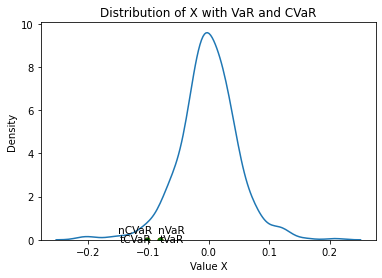

In [9]:
plt.plot()
sns.kdeplot(x_df)
plt.xlabel('Value X')
plt.ylabel('Density')
plt.title('Distribution of X with VaR and CVaR')

# Normal VaR point
plt.scatter([-norm_VaR],[0], s=25, c='r')
plt.text((-norm_VaR+0.02),0.2, 'nVaR', ha='center', va='bottom', fontsize=10.5)

# Normal CVaR point
plt.scatter([-norm_CVaR],[0], s=25, c='r')
plt.text((-norm_CVaR-0.02),0.2, 'nCVaR', ha='center', va='bottom', fontsize=10.5)

# tVaR point
plt.scatter([-t_VaR],[0], s=25, c='g')
plt.text((-t_VaR+0.02),-0.2, 'tVaR', ha='center', va='bottom', fontsize=10.5)

# Normal CVaR point
plt.scatter([-t_CVaR],[0], s=25, c='g')
plt.text((-t_CVaR-0.02),-0.2, 'tCVaR', ha='center', va='bottom', fontsize=10.5)

<font size="5">**Question 2**

See in "library.ipynb"

<font size="5">**Question 3**

In [10]:
portfolio = pd.read_csv(r'portfolio.csv')
daily_price = pd.read_csv(r'DailyPrices.csv')

In [11]:
portA = portfolio.loc[portfolio['Portfolio'] == "A"][["Stock", "Holding"]]
portB = portfolio.loc[portfolio['Portfolio'] == "B"][["Stock", "Holding"]]
portC = portfolio.loc[portfolio['Portfolio'] == "C"][["Stock", "Holding"]]
port = portfolio[["Stock", "Holding"]]

A = pd.Series(range(len(portA)))
B = pd.Series(range(len(portB)))
C = pd.Series(range(len(portC)))
portA = portA.set_index(A)
portB = portB.set_index(B)
portC = portC.set_index(C)

In [12]:
def getWeight(portfolio):
    stock = portfolio['Stock']
    holding = portfolio['Holding']
    price = daily_price[stock]
    weight = np.zeros((len(stock),1))
    tot = 0
    
    for i in range(len(stock)):
        tot += holding[i] * daily_price[stock[i]].iloc[0]
    for i in range(len(stock)):
        w = (holding[i] * daily_price[stock[i]].iloc[0]) / tot
        weight[i] = w
    
    return weight

In [13]:
def getValue(portfolio, weight):
    stock = portfolio['Stock']
    n = len(portfolio)
    price = daily_price[stock]
    port_value = weight.T @ price.T
    return port_value.T

In [14]:
def getReturn(value):
    returns = value.pct_change()
    returns = returns - returns.mean()
    returns_std = returns.std()
    
    return returns, returns_std

In [15]:
w1 = getWeight(portA)
w2 = getWeight(portB)
w3 = getWeight(portC)
w = getWeight(port)

In [16]:
value1 = getValue(portA,w1)
value2 = getValue(portB,w2)
value3 = getValue(portC,w3)
value = getValue(port, w)

In [17]:
returns1, std1 = getReturn(value1)
returns2, std2 = getReturn(value2)
returns3, std3 = getReturn(value3)
returns, std = getReturn(value)

In [18]:
def get_VaR_CVaR(returns, std):
    dof = len(returns) - 1
    mean = returns.mean()
    t_VaR = calc_VaR(mean, std, 't-distribution', alpha, dof)
    t_CVaR = calc_CVaR(mean, std, 't-distribution', alpha, dof)
    
    return t_VaR, t_CVaR

In [19]:
alpha = 5
VaR1, CVaR1 = get_VaR_CVaR(returns1, std1)
VaR2, CVaR2 = get_VaR_CVaR(returns2, std2)
VaR3, CVaR3 = get_VaR_CVaR(returns3, std3)
VaR, CVaR = get_VaR_CVaR(returns, std)

In [20]:
port_VaR = [VaR1[0], VaR2[0], VaR3[0], VaR[0]]
port_CVaR = [CVaR1[0], CVaR2[0], CVaR3[0], CVaR[0]]
port_names = ['Portfolio_A', 'Portfolio_B', 'Portfolio_C', 'Whole_Portfolio']

In [21]:
ans = pd.DataFrame(list(zip(port_names, port_VaR, port_CVaR)), columns = ['Name','VaR', 'CVaR'])
ans

,Name,VaR,CVaR
0,Portfolio_A,0.021169,0.026364
1,Portfolio_B,0.019104,0.023793
2,Portfolio_C,0.017026,0.021205
3,Whole_Portfolio,0.017594,0.021912
